# Westeros Part 1 - Welcome to the MESSAGEix framework & Creating a baseline scenario 

### *Integrated Assessment Modeling for the 21st Century*

For information on how to install *MESSAGEix*, please refer to [Installation page](https://message.iiasa.ac.at/en/stable/getting_started.html) and for getting *MESSAGEix* tutorials, please follow the steps mentioned in [Tutorials](https://message.iiasa.ac.at/en/stable/tutorials.html).

Please refer to the [user guidelines](https://github.com/iiasa/message_ix/blob/master/NOTICE.rst)
for additional information on using *MESSAGEix*, including the recommended citation and how to name new models.

**Structure of these tutorials.** After having run this baseline tutorial, you are able to start with any of the other tutorials, but we recommend to follow the order below for going through the information step-wise:

1. Baseline tutorial (``westeros_baseline.ipynb``)
2. Add extra detail and constraints to the model
    1. Emissions
        1. Introducing emissions (`westeros_emissions_bounds.ipynb`)
        2. Introducing taxes on emissions (`westeros_emissions_taxes.ipynb`)
    2. Add firm capacity (``westeros_firm_capacity.ipynb``)
    3. Add flexible energy generation (``westeros_flexible_generation.ipynb``)
    4. Add seasonality as an example of temporal variability (``westeros_seasonality.ipynb``)
3. Post-processing: learn how to report calculations _after_ the MESSAGE model has run (``westeros_report.ipynb``)

**Pre-requisites**
- Have succesfully installed *MESSAGEix*.

_This tutorial is based on a presentation by Matthew Gidden ([@gidden](https://github.com/gidden))
for a summer school at the the **Centre National de la Recherche Scientifique (CNRS)**
on *Integrated Assessment Modeling* in June 2018._

## Scope of this tutorial: Building a Simple Energy Model

The goal of this tutorial is to build a simple energy model using *MESSAGEix* with minimal features that can be expanded in future tutorials.  

We will build the model component by component, focusing on both the **how** (code implementation) and **why** (mathematical formulation).

## MESSAGEix: the mathematical paradigm

At its core, *MESSAGEix* is an optimization problem:

> $\min \quad ~c^T \cdot x$  
> $~s.t. \quad A \cdot x \leq b$

More explicitly, the model...
- optimizes an **objective function**, nominally minimizing total **system costs**
- under a system of **constraints** (inequalities or equality conditions)

The mathematical implementation includes a number of features that make it particularly geared towards the modelling of *energy-water-land systems* in the context of *climate change mitigation and sustainable development*.

Throughout this document, the mathematical formulation follows the convention that
- decision **VARIABLES** ($x$) are capitalized
- input **parameters** ($A$, $b$) are lower case

## MESSAGEix: connected to the *ix modeling platform (ixmp)*

The *modeling platform for integrated and cross-cutting analysis* (ixmp) provides a powerful framework for working with scenarios, including a database infrastucture for data version control and interfaces to scientific programming languages.



## Ready, steady, go!

First, we import all the packages we need. We import a utility function called *make_df*, which can be used to wrap the input data into dataframes that can be saved in model parameters.

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

The *MESSAGEix* model is built using the *ixmp* `Platform`. The `Platform` is your connection to a database for storing model input data and scenario results.

In [2]:
mp = ixmp.Platform()

Once connected, we create a new `Scenario` to build our model. A `Scenario` instance will contain all the model input data and results.

In [3]:
scenario = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scenario='baseline',version='new')

## Model Structure

We start by defining basic characteristics of the model, including time, space, and the energy system structure.

The model horizon will span 3 decades (690-720). Let's assume that we're far in the future after the events of A Song of Ice and Fire (which occur ~300 years after Aegon the conqueror).

| Math Notation | Model Meaning                |
|---------------|------------------------------|
| $y \in Y^H$   | time periods in history      |
| $y \in Y^M$   | time periods in model horizon|

In [4]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon({'year': history + model_horizon,  
                      'firstmodelyear': model_horizon[0]})

Our model will have a single `node`, i.e., its spatial dimension.


| Math Notation | Model Meaning|
|---------------|--------------|
| $n \in N$     | node         |

In [5]:
country = 'Westeros'
scenario.add_spatial_sets({'country': country})

And we fill in the energy system's `commodities`, `levels`, `technologies`, and `modes` (i.e., modes of operation of technologies). This information defines how certain technologies operate. 


| Math Notation | Model Meaning|
|---------------|--------------|
| $c \in C$     | commodity    |
| $l \in L$     | level        |
| $t \in T$     | technology   |
| $m \in M$     | mode         |


© IEA ETSAP - Technology Brief E02 – April 2010 - www.etsap.org will be used as a source of gas_ppl data.

Modified step for gas:
* gas_ppl is added as technology

In [6]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ['coal_ppl', 'gas_ppl', 'wind_ppl', 'grid', 'bulb'])
scenario.add_set("mode", "standard")

## Supply and Demand (or Balancing Commodities)

The fundamental premise of the model is to satisfy demand for energy (services).
To first order, demand for services like electricity track with economic productivity (GDP).
We define a GDP profile similar to first-world GDP growth from [1900-1930](https://en.wikipedia.org/wiki/List_of_regions_by_past_GDP):

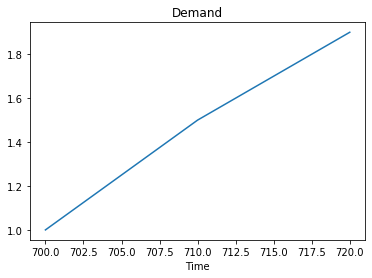

In [7]:
gdp_profile = pd.Series([1., 1.5, 1.9],
                        index=pd.Index(model_horizon, name='Time'))
gdp_profile.plot(title='Demand')

The `COMMODITY_BALANCE_GT` and `COMMODITY_BALANCE_LT` equations ensure that `demand` for each `commodity` is met at each `level` in the energy system.
The equation is copied below in this tutorial notebook, but every model equation is available for reference in
the [Mathematical formulation](https://message.iiasa.ac.at/en/stable/model/MESSAGE/model_core.html#) section of the *MESSAGEix* documentation.

$\sum_{\substack{n^L,t,m \\ y^V \leq y}} \text{output}_{n^L,t,y^V,y,m,n,c,l} \cdot \text{ACT}_{n^L,t,y^V,y,m}$
$- \sum_{\substack{n^L,t,m, \\ y^V \leq y}} \text{input}_{n^L,t,y^V,y,m,n,c,l} \cdot \text{ACT}_{n^L,t,m,y}$  
$\geq \text{demand}_{n,c,l,y} \quad \forall \ l \in L$

While `demand` must be met, supply can *exceed* demand allowing the model to plan for meeting demand in future periods by storing storable commodities.


First we establish demand. Let's assume

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- a per capita demand for electricity of 1000 kWh
- and 8760 hours in a year (of course!)

Then we can add the demand parameter

Note present day: [~72000 GWh in Austria](https://www.iea.org/statistics/?country=AUSTRIA&year=2016&category=Energy%20consumption&indicator=undefined&mode=chart&dataTable=INDICATORS) with population [~8.7M](http://www.austria.org/population/) which is ~8300 kWh per capita

In [8]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': model_horizon,
        'time': 'year',
        'value': (100 * gdp_profile).round(),
        'unit': 'GWa',
    })

`light_demand` illustrates the data format for *MESSAGEix* parameters. It is a `pandas.DataFrame` containing three types of information in a specific format:

- A "value" column containing the numerical values for this parameter.
- A "unit" column.
- Other columns ("node", "commodity", "level", "time") that indicate the key to which each value applies.

In [9]:
light_demand

,node,commodity,level,year,time,value,unit
Time,,,,,,,
700,Westeros,light,useful,700,year,100.0,GWa
710,Westeros,light,useful,710,year,150.0,GWa
720,Westeros,light,useful,720,year,190.0,GWa


In [10]:
# We use add_par for adding data to a MESSAGEix parameter
scenario.add_par("demand", light_demand)

In order to define the input and output commodites of each technology, we define some common keys.

- **Input** quantities require `_origin` keys that specify where the inputs are *received from*.
- **Output** quantities require `_dest` keys that specify where the outputs are *transferred to*.

In [11]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

Working backwards along the Reference Energy System, we can add connections for the `bulb`. A light bulb…

- receives *input* in the form of the "electricity" *commodity* at the "final [energy]" *level*, and
- *outputs* the commodity "light" at the "useful [energy]" level.

The `value` in the input and output parameter is used to represent the effiecieny of a technology (efficiency = output/input).
For example, input of 1.0 and output of 1.0 for a technology shows that the efficiency of that technology is 100% in converting
the input commodity to the output commodity.

In [12]:
bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=1.0)
scenario.add_par('output', bulb_out)

bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
                  level='final', value=1.0)
scenario.add_par('input', bulb_in)

Next, we parameterize the electrical `grid`, which…

- receives electricity at the "secondary" energy level.
- also outputs electricity, but at the "final" energy level (to be used by the light bulb).

Because the grid has transmission losses, only 90% of the input electricity is available as output.

In [13]:
grid_efficiency = 0.9
grid_out = make_df(base_output, technology='grid', commodity='electricity', 
                   level='final', value=grid_efficiency)
scenario.add_par('output', grid_out)

grid_in = make_df(base_input, technology='grid', commodity='electricity',
                  level='secondary', value=1.0)
scenario.add_par('input', grid_in)

And finally, our power plants. The model does not include the fossil resources used as `input` for coal plants and gas power plants; however, costs of coal and gas extraction are included in the parameter $variable\_cost$.

In [14]:
coal_out = make_df(base_output, technology='coal_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', coal_out)

gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', gas_out)

wind_out = make_df(base_output, technology='wind_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', wind_out)

## Operational Constraints and Parameters

The model has a number of "reality" constraints, which relate built *capacity* (`CAP`) to available power, or the *activity* (`ACT`) of that technology.

The **capacity constraint** limits the activity of a technology to the installed capacity multiplied by a capacity factor. Capacity factor or is the fraction of installed capacity that can be active in a certain period (here the sub-annual time step *h*).

$$\sum_{m} \text{ACT}_{n,t,y^V,y,m,h}
    \leq \text{duration_time}_{h} \cdot \text{capacity_factor}_{n,t,y^V,y,h} \cdot \text{CAP}_{n,t,y^V,y}
    \quad t \ \in \ T^{INV}$$


This requires us to provide the `capacity_factor` for each technology. Here, we call `make_df()` and `add_par()` in a loop to execute similar code for three technologies:

In [15]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

* gas_ppl capacity factor = 1

In [16]:
capacity_factor = {
    'coal_ppl': 1,
    'gas_ppl':1,
    'wind_ppl': 0.36,
    'bulb': 1, 
   
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

The model can further be provided `technical_lifetime`s in order to properly manage deployed capacity and related costs via the **capacity maintenance** constraint:

$\text{CAP}_{n,t,y^V,y} \leq \text{remaining_capacity}_{n,t,y^V,y} \cdot \text{value} \quad \forall \quad t \in T^{INV}$

where `value` can take different forms depending on what time period is considered:

| Value                               | Condition                                           |
|-------------------------------------|-----------------------------------------------------|
| $\Delta_y \text{historical_new_capacity}_{n,t,y^V}$ | $y$ is first model period           |
| $\Delta_y \text{CAP_NEW}_{n,t,y^V}$ | $y = y^V$                                           |
| $\text{CAP}_{n,t,y^V,y-1}$          | $0 < y - y^V < \text{technical_lifetime}_{n,t,y^V}$ |


In [17]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

* gas_ppl lifetime = 30 

In [18]:
lifetime = {
    'coal_ppl': 20,
    'gas_ppl':30,
    'wind_ppl': 20,
    'bulb': 1,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

## Technological Diffusion and Contraction

We know from historical precedent that energy systems can not be transformed instantaneously. Therefore, we use a family of dynamic constraints on activity and capacity. These constraints define the upper and lower limit of the domain of activity and capacity over time based on their value in the previous time step, an initial value, and growth/decline rates.

$\sum_{y^V \leq y,m} \text{ACT}_{n,t,y^V,y,m,h} \leq$  
$\text{initial_activity_up}_{n,t,y,h}
        \cdot \frac{ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} - 1 }
                   { growth\_activity\_up_{n,t,y,h} }+ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} \cdot \Big( \sum_{y^V \leq y-1,m} ACT_{n,t,y^V,y-1,m,h} + \sum_{m} historical\_activity_{n,t,y-1,m,h}\Big)$  

This example limits the ability for technologies to **grow**. To do so, we  need to provide `growth_activity_up` values for each technology that we want to model as being diffusion constrained. Here, we set this constraint at 10% per year.

In [19]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [20]:
growth_technologies = [
    "coal_ppl",
    "gas_ppl",
    "wind_ppl", 
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1) 
    scenario.add_par('growth_activity_up', df)

## Defining an Energy Mix (Model Calibration)

To model the transition of an energy system, one must start with the existing system which are defined by the parameters `historical_activity` and `historical_new_capacity`. These parameters define the energy mix before the model horizon.  

We begin by defining a few key values:

- how much useful energy was needed
- how much final energy was generated
- and the mix for different technologies

In [21]:
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.4

In [22]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

Then, we can define the **activity** and **capacity** in the historic period

The part of each power plants for electricity generation:
'coal_ppl'=40%, 'gas_ppl'=20% , 'wind_ppl'=40%

In [23]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'gas_ppl': 0.2 * historic_generation,
    'wind_ppl': 0.4* historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('historical_activity', df)

In this part, new capacity will be defined for each power plant.

In [24]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'gas_ppl': 1 / 10 / capacity_factor['gas_ppl'] / 3,# 30 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,# 20 year lifetime
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scenario.add_par('historical_new_capacity', df)

Objective Function

The objective function drives the purpose of the optimization. Do we wish to seek maximum utility of the social planner, minimize carbon emissions, or something else? Classical IAMs seek to minimize total discounted system cost over space and time. 

$$\min \sum_{n,y \in Y^{M}} \text{interestrate}_{y} \cdot \text{COST_NODAL}_{n,y}$$


First, let's add the interest rate parameter.

In [25]:
scenario.add_par("interestrate", model_horizon, value=0.05, unit='-')

`COST_NODAL` is comprised of a variety of costs related to the use of different technologies.

### Investment Costs

Capital, or investment, costs are invoked whenever a new plant or unit is built

$$\text{inv_cost}_{n,t,y} \cdot \text{construction_time_factor}_{n,t,y} \cdot \text{CAP_NEW}_{n,t,y}$$

In [26]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')     

INFO:root:unit `USD/kW` is already defined in the platform instance


* gas_ppl investment costs = 1000

In [27]:
# in $ / kW (specific investment cost)
costs = {
    'coal_ppl': 500,
    'gas_ppl' : 1000,
    'wind_ppl': 1500,
    'bulb': 5,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

### Fixed O&M Costs

Fixed cost are only relevant as long as the capacity is active. This formulation allows to include the potential cost savings from early retirement of installed capacity.

$$\sum_{y^V \leq y} \text{fix_cost}_{n,t,y^V,y} \cdot \text{CAP}_{n,t,y^V,y}$$

In [28]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

In [29]:
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    'coal_ppl': 30,
    'gas_ppl': 36,
    'wind_ppl': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

### Variable O&M Costs

Variable Operation and Maintence costs are associated with the costs of actively running the plant. Thus, they are not applied if a plant is on standby (i.e., constructed, but not currently in use).

$$\sum_{\substack{y^V \leq y \\ m,h}} \text{var_cost}_{n,t,y^V,y,m,h} \cdot \text{ACT}_{n,t,y^V,y,m,h} $$

In [30]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [31]:
# in $ / kWa (costs associatied to the degradation of equipment when the plant is functioning
# per unit of energy produced kW·year = 8760 kWh.
# Therefore this costs represents USD per 8760 kWh of energy). Do not confuse with fixed O&M units.

costs = {
    'coal_ppl': 30,
    'gas_ppl': 36,
    'grid': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scenario.add_par('var_cost', df)

A full model will also have costs associated with

- costs associated with technologies (investment, fixed, variable costs)
- resource extraction: $\sum_{c,g} \ resource\_cost_{n,c,g,y} \cdot EXT_{n,c,g,y} $
- emissions
- land use (emulator): $\sum_{s} land\_cost_{n,s,y} \cdot LAND_{n,s,y}$

## Time to Solve the Model

First, we *commit* the model structure and input data (sets and parameters).
In the `ixmp` backend, this creates a new model version in the database, which is assigned a version number automatically:

In [32]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scenario.version))

scenario.commit(comment='basic model of Westeros electrification')

log.info('version number prior committing to the database: {}'.format(scenario.version))

INFO:message_ix:version number prior to commit: 0
INFO:message_ix:version number prior committing to the database: 127


An `ixmp` database can contain many scenarios, and possibly multiple versions of the same model and scenario name.
These are distinguished by unique version numbers.

To make it easier to retrieve the "correct" version (e.g., the latest one), you can set a specific scenario as the default version to use if the "Westeros Electrified" model is loaded from the `ixmp` database.

In [33]:
scenario.set_as_default()

In [34]:
scenario.solve()

In [35]:
scenario.var('OBJ')['lvl']

245710.046875

In [36]:
scenario.var('PRICE_COMMODITY')

,node,commodity,level,year,time,lvl,mrg
0,Westeros,electricity,secondary,700,year,405.643395,0.0
1,Westeros,electricity,secondary,710,year,90.980599,0.0
2,Westeros,electricity,secondary,720,year,90.980599,0.0
3,Westeros,electricity,final,700,year,506.270438,0.0
4,Westeros,electricity,final,710,year,156.645110,0.0
5,Westeros,electricity,final,720,year,156.645110,0.0
6,Westeros,light,useful,700,year,511.270438,0.0
7,Westeros,light,useful,710,year,161.645110,0.0
8,Westeros,light,useful,720,year,161.645110,0.0


In [37]:
scenario.par('historical_activity')

,node_loc,technology,year_act,mode,time,value,unit
0,Westeros,coal_ppl,690,standard,year,20.700152,GWa
1,Westeros,gas_ppl,690,standard,year,10.350076,GWa
2,Westeros,wind_ppl,690,standard,year,20.700152,GWa


In [38]:
scenario.par('historical_new_capacity')

,node_loc,technology,year_vtg,value,unit
0,Westeros,coal_ppl,690,1.035008,GWa
1,Westeros,gas_ppl,690,0.345003,GWa
2,Westeros,wind_ppl,690,2.875021,GWa


## Plotting Results

We make use of some custom code for plotting the results; see `tools.py` in the tutorial directory.

In [39]:
from tools import Plots
p = Plots(scenario, country, firstyear=model_horizon[0])

### Activity

How much energy is generated in each time period from the different potential sources?

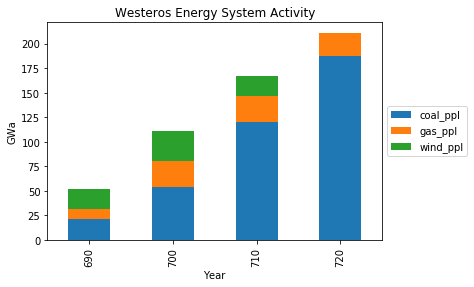

In [40]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Capacity

How much capacity of each plant is installed in each period?

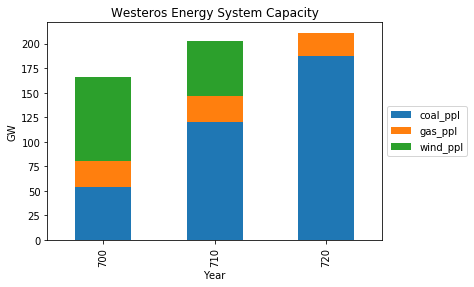

In [41]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution.
They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of
electricity), which is in fact the marginal cost of the most expensive operating generator.  

Note the price drop when the most expensive technology is no longer in the system.

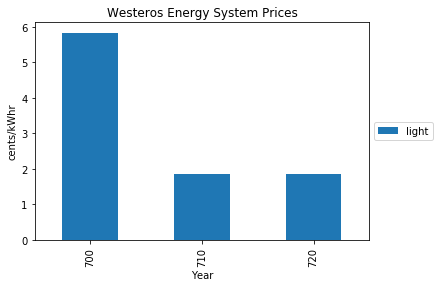

In [42]:
p.plot_prices(subset=['light'], baseyear=True)

## Close the connection to the database

When working with local HSQLDB database instances, you cannot connect to one database from multipe Jupyter notebooks (or processes) at the same time.

If you want to easily switch between notebooks with connections to the same `ixmp` database, you need to close the connection in one notebook before initializing the platform using `ixmp.Platform()` in another notebook.

After having closed the database connection, you can reopen it using
```
mp.open_db()
```

In [43]:
mp.close_db()

## Congratulations! 

You have built and run your very first *MESSAGEix* model. Welcome to the community!

The next tutorials will introduce you to other features of the framework, including energy system constraints, emissions taxes, and other policy options.

Check us out on Github https://github.com/iiasa/message_ix  
and get in touch with us online https://groups.google.com/forum/message-ix ...